# 1. Sarsa Algorithm and the OpenAI Gym's Taxi Environment

## Introduction

Tabular methods are suitable for small and discrete state space and discrete action space environments. So, the state-action function (Q) can be represented by a table of values. For large state space environments, we prefer to use approximation methods such as neural networks. However, the simplicity of tabular methods' implementation is helpful to demonstrate RL method's functionality. In this notebook, we train a SARSA agent for OpenAI's Taxi Gym environment .

## Goal

In this notebook, we are going to resolve the <a href="https://gym.openai.com/envs/Taxi-v2/">Taxi environment</a> (an example originally proposed by Tom Dietterich) with the SARSA and Q-Learning algorithms. Once we implement SARSA, implementing Q-Learning and many others (e.g., Expected SARSA, Double Q-learning, etc.) would be easy. We usually need to change the core update method.

## The Taxi Environment

Here is a description of the taxi environment from the [docstring](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py).

The Smartcab's job is to pick up the passenger in a simplified gridworld like environment at one location and drop them off in another ([Taxi, OpenAI Gym](https://gym.openai.com/envs/Taxi-v2/)). Here are a few things that we'd love our Smartcab to take care of:

- Drop off the passenger to the right location.
- Save passenger's time by taking minimum time possible to drop off
- Take care of passenger's safety and traffic rules

<center><img style="align: center;" src="https://github.com/FredAmouzgar/comp8220_ML_2021S1/raw/main/images/Taxi_Env.png" width=400></center>

__State__: Let's say we have a training area for our Smartcab where we are teaching it to transport people in a parking lot to four different locations (R, G, Y, B):

Let's assume Smartcab is the only vehicle in this parking lot. We can break up the parking lot into a 5x5 grid, which gives us 25 possible taxi locations. These 25 locations are one part of our state space. Notice the current location state of our taxi is coordinate (3, 1).

You'll also notice there are four (4) locations that we can pick up and drop off a passenger: R, G, Y, B or `[(0,0), (0,4), (4,0), (4,3)]` in (row, col) coordinates. Our illustrated passenger is in location Y and they wish to go to location R.

__Actions__: The agent is allowed to perform six possible actions:

1. south
2. north
3. east
4. west
5. pickup
6. dropoff

Notice in the illustration above, that the taxi cannot perform certain actions in certain states due to walls. In environment's code, we will simply provide a -1 penalty for every wall hit and the taxi won't move anywhere. This will just rack up penalties causing the taxi to consider going around the wall.

### Installations

In [ ]:
!pip -q install gym numpy matplotlib

### Setting up the environment

In [1]:
import gym

# Finding the Taxi environment
for env in gym.envs.registry.all():
    if env.id.startswith("Taxi"):
        env_name = env.id
##


print("Environment Name:", env_name)
env = gym.make(env_name)
env.reset()
env.render()

Environment Name: Taxi-v3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## The SARSA Algorithm
<p> </p><br>
<center><img style="align: center;" src="https://github.com/FredAmouzgar/comp8220_ML_2021S1/raw/main/images/SARSA_algorithm.png" width=900></center>

In [46]:
import numpy as np

class Sarsa_Agent:
    def __init__(self, states_n, actions_n, alpha=0.1, epsilon=1,
                 epsilon_decay_factor=0.0005, epsilon_final_value=0.1,
                 gamma=0.95, epsilon_decay=True):
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.states_n = states_n
        self.actions_n = actions_n
        self.all_actions = np.arange(actions_n)
        self.Q = np.zeros((states_n, actions_n))
        self.new_a = None
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_factor = epsilon_decay_factor
        self.epsilon_final_value = epsilon_final_value

    def act(self, state, exploration=True):
        # epsilon greedy
        if exploration:
            if np.random.rand() < self.epsilon:
                action = np.random.choice(self.all_actions)
            else:
                action = action = np.argmax(self.Q[int(state), :])
        else: # Pure greedy, no exploration
            action = np.argmax(self.Q[state, :])
        return action

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_final_value:
            self.epsilon -= self.epsilon_decay_factor
        else:
            self.epsilon = self.epsilon_final_value
          

    def update(self, new_s, r, s, a, done):
        self.new_a = self.act(new_s)
        mask = 0 if done else 1
        s, a, self.new_a, new_s = int(s), int(a), int(self.new_a), int(new_s)
        self.Q[s, a] += self.alpha * (r + self.gamma * self.Q[new_s, self.new_a] * mask - self.Q[s, a])
        if done and self.epsilon_decay:
            self.decay_epsilon()
        return self.new_a

## Util functions

In [50]:
# Utils - PLEASE DO NOT MODIFY THIS CELL
from time import sleep

def display_status(episode, return_episode, epsilon, stime, returns, avg_returns):
    """
    A helper function for displaying agent's behavior
    """
    clear_output(wait=True)
    etime = time()
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    axes.set_title("Episode:" + str(episode) + " - Return:"+str(return_episode)\
              + " - Epsilon:" + str(epsilon)[:5] + " - elapsed time: " + str(etime - stime)[:4])
    axes.set_xlabel("Episode")
    axes.set_ylabel("Returns (sum of rewards in each episode)")
    axes.plot(list(range(len(returns))),returns)
    axes.plot(list(range(len(returns))),avg_returns, linewidth=3)
    axes.legend(["Returns", "Average Returns"])
    plt.show()
    
def taxi_print_frames(frames, wait_btw_frames, episode):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Passenger #: {episode + 1}")
        print("-----------")
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(wait_btw_frames)
        
def play_taxi(env, agent, passengers=2, wait_btw_frames=1, tolerance=20):
    for episode in range(passengers):
        state = env.reset()
        frames = []
        done = False
        step = 0
        while not done:
            action = agent.act(state, exploration=False)
            new_state, reward, done, _ = env.step(action)
            frames.append({
                'frame': env.render(mode='ansi'),
                'state': state,
                'action': action,
                'reward': reward
            })
            step += 1
            state = new_state
            if step >= tolerance:
                print(f"No Done in {step} steps.")
                break
        taxi_print_frames(frames, wait_btw_frames=wait_btw_frames, episode=episode)

## The Train Loop
<p> </p><br>
<center><img style="align: center;" src="https://github.com/FredAmouzgar/comp8220_ML_2021S1/raw/main/images/MDP_loop.jpeg" width=900></center>

In [48]:
# Making sure we know our Taxi environment version
for env in gym.envs.registry.all():
    if env.id.startswith("Taxi"):
        env_name = env.id
##

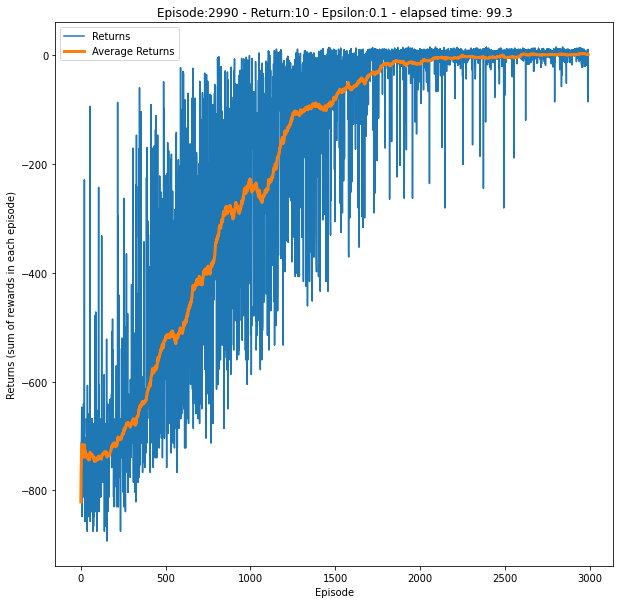

In [49]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import time

env = gym.make(env_name) # Creating the environment
agent = Sarsa_Agent(env.observation_space.n, env.action_space.n) # Initializing the agent
EPISODES = 3000 # Training the agent for 3000 episodes
DISPLAY_RESULTS_INTERVAL = 10

returns = []
avg_returns = []
stime = time()

for episode in range(EPISODES):
    state = env.reset()
    action = agent.act(state)
    done = False
    step_n = 0
    return_episode = 0
    while not done:
        new_state, reward, done, _ = env.step(action)
        return_episode += reward
        new_action = agent.update(new_state,reward,state,action,done)
        state, action = new_state, new_action
        step_n += 1
        if done:
            returns.append(return_episode)
            avg = (sum(returns[-100:]) / 100) if len(returns) > 100 else (sum(returns[-len(returns):]) / len(returns))
            avg_returns.append(avg)
            if episode % DISPLAY_RESULTS_INTERVAL == 0:
                display_status(episode, return_episode, agent.epsilon, stime, returns, avg_returns)
            clear_output(wait=True)

## Watch a smart SARSA self-driving cab:
Note: You can change the number of `passengers` if you want to move more than 3. Change the `wait_btw_frames` if you want to see the game running faster or slower.

In [53]:
play_taxi(env, agent, passengers=3, wait_btw_frames=1)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Passenger #: 3
-----------
Timestep: 13
State: 16
Action: 5
Reward: 20


# 2. Q-Learning Algorithm and the OpenAI Gym's Taxi Environment

## The Q-Learning Algorithm
<p> </p><br>
<center><img style="align: center;" src="https://github.com/FredAmouzgar/comp8220_ML_2021S1/raw/main/images/qlearning.png" width=900></center>

In [54]:
import numpy as np

class Qlearning_Agent:
    def __init__(self, states_n, actions_n, alpha=0.1, epsilon=1,
                 epsilon_decay_factor=0.0005, epsilon_final_value=0.1,
                 gamma=0.95, epsilon_decay=True):
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.states_n = states_n
        self.actions_n = actions_n
        self.all_actions = np.arange(actions_n)
        self.Q = np.zeros((states_n, actions_n))
        self.new_a = None
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_factor = epsilon_decay_factor
        self.epsilon_final_value = epsilon_final_value

    def act(self, state, exploration=True):
        # epsilon greedy
        if exploration:
            if np.random.rand() < self.epsilon:
                action = np.random.choice(self.all_actions)
            else:
                action = action = np.argmax(self.Q[int(state), :])
        else: # Pure greedy, no exploration
            action = np.argmax(self.Q[state, :])
        return action

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_final_value:
            self.epsilon -= self.epsilon_decay_factor
        else:
            self.epsilon = self.epsilon_final_value
          

    def update(self, new_s, r, s, a, done):
        mask = 0 if done else 1
        s, a, new_s = int(s), int(a), int(new_s)
        self.Q[s, a] += self.alpha * (r + self.gamma * np.max(self.Q[new_s, :]) * mask - self.Q[s, a])
        if done and self.epsilon_decay:
            self.decay_epsilon()

## The Train Loop

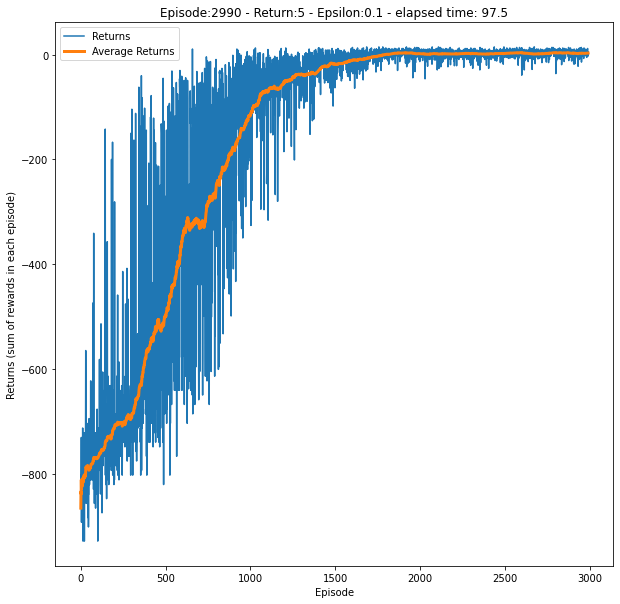

In [58]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import time

env = gym.make(env_name) # Creating the environment
agent = Qlearning_Agent(env.observation_space.n, env.action_space.n) # Initializing the agent
EPISODES = 3000 # Training the agent for 3000 episodes
DISPLAY_RESULTS_INTERVAL = 10

returns = []
avg_returns = []
stime = time()

for episode in range(EPISODES):
    state = env.reset()
    done = False
    step_n = 0
    return_episode = 0
    while not done:
        action = agent.act(state)
        new_state, reward, done, _ = env.step(action)
        return_episode += reward
        new_action = agent.update(new_state,reward,state,action,done)
        state = new_state
        step_n += 1
        if done:
            returns.append(return_episode)
            avg = (sum(returns[-100:]) / 100) if len(returns) > 100 else (sum(returns[-len(returns):]) / len(returns))
            avg_returns.append(avg)
            if episode % DISPLAY_RESULTS_INTERVAL == 0:
                display_status(episode, return_episode, agent.epsilon, stime, returns, avg_returns)
            clear_output(wait=True)

## Watch a smart Q-Learning self-driving cab:
Note: You can change the number of `passengers` if you want to move more than 3. Change the `wait_btw_frames` if you want to see the game running faster or slower.

In [59]:
play_taxi(env, agent, passengers=3, wait_btw_frames=1)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Passenger #: 3
-----------
Timestep: 10
State: 97
Action: 5
Reward: 20


# How the learning happened?

The Sarsa and Q-Learning agents are implementing a __tabular method__ which means that they're updating a table of values iteratively. As said before, this table is called Q-table. After the training, the agent knows exactly which actions are the best in almost all possible states.

In __Approximation methods__ and __Deep Reinforcement Learning__, this table is replaced by a linear model or a [neural network](https://www.nature.com/articles/nature14236). A well-designed network can learn much more complex tasks, generalizes, and thus responds better to unseen situations.

__Take a look at the Pigoen Pong Experiment__ (special thanks go to <a href="https://complexity-in-action.github.io/people/patricknalepka.html">Dr. Patrick Nalepka</a>): Artificial agents follow the same process. __We'll show an agent with neural network on week 12.__

In [4]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/vGazyH6fQQ4" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

<img style="align: center;" src="https://github.com/FredAmouzgar/comp8220_ML_2021S1/raw/main/images/pong.gif" width=200>

# More Questions:

Q1: Compare the performance of SARSA and the Q-learning algorithms. Which one outperforms the other? Can you think of a reason for this difference?

## Extra Questions (do them in your own time)

Q2 (programming): Apply SARSA and Q-Learning to the WindyGridWorld environment and compare their perfomances with the On-policy Monte-Carlo algorithm.

*Q3 (programming): Study the Expected SARSA algorithm \[[Sutton2018, 6.6](http://incompleteideas.net/book/the-book-2nd.html)\], implement it and compare its performance in the Taxi environment with SARSA and Q-Learning.

<font size="1px">* = harder questions</font>

<font size="1px">A modified version of our <a href="https://github.com/probml/pyprobml/blob/master/book2/supplements/rl/Tabular_SARSA.ipynb">joint work</a> with Prof. Kevin Murphy for the second edition of his book, <a href="https://probml.github.io/pml-book/">Machine Learning: A Probabilistic Perspective</a></font>

<font size="1px"><a href="https://www.linkedin.com/in/fredamouzgar/">Fred A.</a> Mar/2021</font>